# Dependence-Of-Regions.ipynb

#!/usr/bin/env python

    File name: Dependence-Of-Regions.ipynb
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 19.04.2018
    Date last modified: 19.04.2018

    ############################################################## 
    Purpos:
    Investigate which variables were most frequently picked in settings with good performance.
    
    This requires to first run:
    ~/papers/Extreme-WTs-US/programs/Extreme-WTs/SearchOptimum_XWT-Combination.py

    1) read in the cluster assignment of each day in all region

    2) read in the average daily precipitation in the region

    3) calculate skill scores for all reagions using a single-regions cluster assignment
    
    4) if two regions have similar clusters the skill scores should be similar to using the
       regions own clusters


In [1]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
from mpl_toolkits import basemap
import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import scipy
import shapefile
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
# Cluster specific modules
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans2,vq, whiten
from scipy.ndimage import gaussian_filter
import seaborn as sns
# import metpy.calc as mpcalc
import shapefile as shp
import sys
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile
from scipy import signal
from numpy.linalg import lstsq
import random

def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

### Setup

In [2]:
sPlotDir='/glade/u/home/prein/projects/Arizona_WTing/plots/Dependence-Of_Regions/'
sDataDir='/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/HandK/'
DW_Regions=['1501','1502','1503','1504','1505','1506','1507','1810','HUC6-00','HUC6-01','HUC6-02','HUC6-03','HUC6-04','HUC6-05']
sRegNames=['1501','1502','1503','1504','1505','1506','1507','1810', '130100','130201','130202','130600','130301','140801']
HUC6 = ['130100','130201','130202','130600','130301','140801']
sMonths='6-7-8-9-10'
Season = 'JJASO'
YYYY_stamp='1982-2018'
rgsWTvars=['PSL','U850','V850','UV850','MFL850',  'MFL500', 'Q850', 'Q500', 'ZG500', 'UV200','T850','T500']
iNrOfExtremes = 13514

VarComp = [['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850']]

PercVarSel=10

### Load the Eucledian Distances and the Daily Precipitation for each Region

In [3]:
for re in range(len(DW_Regions)):
    sRegion=DW_Regions[re]
    ss='-'
    VarsJoint=ss.join(VarComp[re])
    sClusterSave='/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/HandK/Clusters'+str(iNrOfExtremes)+'_'+sRegion+'_'+YYYY_stamp+'_'+VarsJoint+'_'+Season
    with open(sClusterSave, 'rb') as handle:
        DATA = pickle.load(handle)
    grEucledianDist = DATA['grEucledianDist']['Full']
    rgdTime = DATA['rgdTime']
    Peval = DATA['Peval']
    ClusterArray = DATA['grClustersFin']['Full'][1]
    LonWT = DATA['LonWT']
    LatWT = DATA['LatWT']
    if re == 0:
        PR_All = np.zeros((len(rgdTime),len(DW_Regions))); PR_All[:]=np.nan
        PR_All_GC = np.zeros((len(rgdTime), 10000, len(DW_Regions))); PR_All[:]=np.nan
        Cluster_All = np.copy(PR_All)
    
    sPRsave='/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/HandK/Precipitation-Records_'+str(iNrOfExtremes)+'_'+sRegion+'_'+YYYY_stamp+'_'+sMonths+'.npz'
    npzfile = np.load(sPRsave)
    rgrPRrecords=npzfile['rgrPRrecords']
    
    PR_All[:,re] = rgrPRrecords
    Cluster_All[:,re] = ClusterArray
    PR_All_GC[:,:Peval.shape[1],re]=Peval
    

### calculate statistics for all possible permutations

In [4]:
# basin average PR

In [5]:
ANOMALY = np.zeros((len(DW_Regions),len(DW_Regions))); ANOMALY[:] = np.nan
IvI = np.copy(ANOMALY)
for re0 in range(len(DW_Regions)):
    for re1 in range(len(DW_Regions)):
        PR_Centroids_test = np.array([np.nanmean(PR_All[Cluster_All[:,re0] == ce,re1]) for ce in np.unique(Cluster_All[:,re0])])
#         print(PR_Centroids_test)
#         print(np.nanmean(PR_All[:,re1]))
        ANOMALY[re0,re1] = np.mean(np.abs(1-(PR_Centroids_test/np.nanmean(PR_All[:,re1]))))
        IntraClusterSTD = np.nanstd(PR_All[:,re1], axis=0)
        InterClusterSTD = np.array([np.std(PR_All[Cluster_All[:,re0] == ce,re1], axis=0) for ce in np.unique(Cluster_All[:,re0])])
        IvI[re0,re1] = IntraClusterSTD/np.mean(InterClusterSTD)

[Text(0.5, 0, '1501'),
 Text(1.5, 0, '1502'),
 Text(2.5, 0, '1503'),
 Text(3.5, 0, '1504'),
 Text(4.5, 0, '1505'),
 Text(5.5, 0, '1506'),
 Text(6.5, 0, '1507'),
 Text(7.5, 0, '1810'),
 Text(8.5, 0, '130100'),
 Text(9.5, 0, '130201'),
 Text(10.5, 0, '130202'),
 Text(11.5, 0, '130600'),
 Text(12.5, 0, '130301'),
 Text(13.5, 0, '140801')]

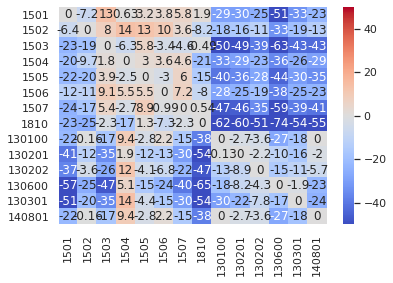

In [6]:
import seaborn as sns; sns.set()
AnomDiff = np.zeros((len(DW_Regions),len(DW_Regions))); AnomDiff[:] = np.nan
for re1 in range(len(DW_Regions)):
    for re2 in range(len(DW_Regions)):
        AnomDiff[re1,re2] = ((ANOMALY[re1,re2]-ANOMALY[re2,re2])/ANOMALY[re2,re2])*100


ax=sns.heatmap(AnomDiff[:,:], cmap='coolwarm', vmin=-50, vmax=50, annot = True)
ax.set_yticklabels(sRegNames, rotation=0)
ax.set_xticklabels(sRegNames, rotation=90)

[Text(0.5, 0, '1501'),
 Text(1.5, 0, '1502'),
 Text(2.5, 0, '1503'),
 Text(3.5, 0, '1504'),
 Text(4.5, 0, '1505'),
 Text(5.5, 0, '1506'),
 Text(6.5, 0, '1507'),
 Text(7.5, 0, '1810'),
 Text(8.5, 0, '130100'),
 Text(9.5, 0, '130201'),
 Text(10.5, 0, '130202'),
 Text(11.5, 0, '130600'),
 Text(12.5, 0, '130301'),
 Text(13.5, 0, '140801')]

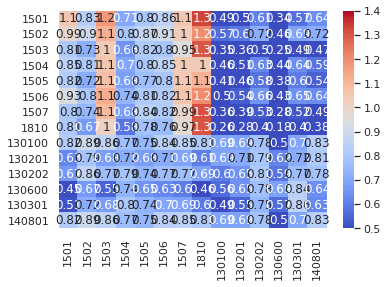

In [7]:
import seaborn as sns; sns.set()
ax=sns.heatmap(ANOMALY[:,:], cmap='coolwarm', vmin=0.5, vmax=1.4, annot = True)
ax.set_yticklabels(sRegNames, rotation=0)
ax.set_xticklabels(sRegNames, rotation=90)

[Text(0.5, 0, '1501'),
 Text(1.5, 0, '1502'),
 Text(2.5, 0, '1503'),
 Text(3.5, 0, '1504'),
 Text(4.5, 0, '1505'),
 Text(5.5, 0, '1506'),
 Text(6.5, 0, '1507'),
 Text(7.5, 0, '1810'),
 Text(8.5, 0, '130100'),
 Text(9.5, 0, '130201'),
 Text(10.5, 0, '130202'),
 Text(11.5, 0, '130600'),
 Text(12.5, 0, '130301'),
 Text(13.5, 0, '140801')]

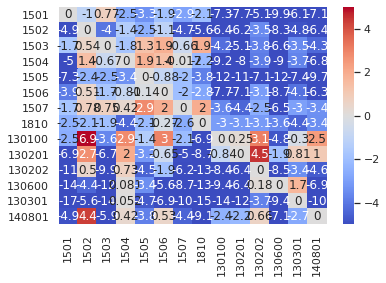

In [8]:
import seaborn as sns; sns.set()
IvIDiff = np.zeros((len(DW_Regions),len(DW_Regions))); IvIDiff[:] = np.nan
for re in range(len(DW_Regions)):
    IvIDiff[re,:] = ((IvI[re,:]-IvI[re,re])/IvI[re,re])*100
    
ax=sns.heatmap(IvIDiff[:,:], cmap='coolwarm', vmin=-5, vmax=5, annot = True)
ax.set_yticklabels(sRegNames, rotation=0)
ax.set_xticklabels(sRegNames, rotation=90)

### plot results on map

        Plot map to: /glade/u/home/prein/projects/Arizona_WTing/plots/Dependence-Of_Regions/Dependence-Of_Regions.pdf


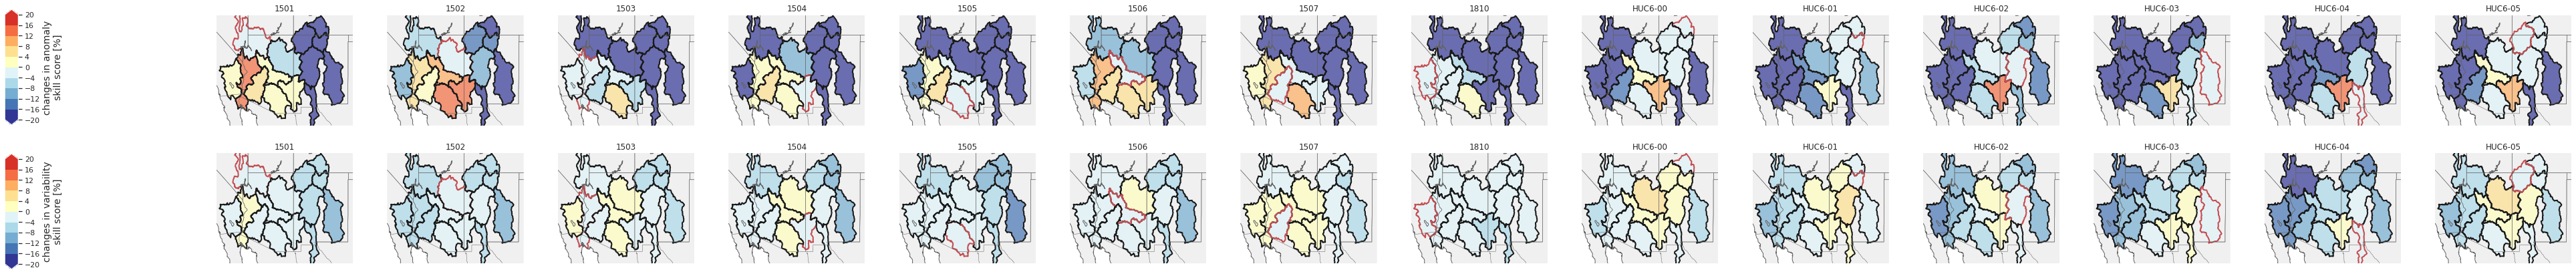

In [9]:
from mpl_toolkits import basemap
plt.rcParams.update({'font.size': 13})
rgsLableABC=list(string.ascii_lowercase)

fig = plt.figure(figsize=(55,6))

gs1 = gridspec.GridSpec(2,len(DW_Regions))
gs1.update(left=0.09, right=0.98,
           bottom=0.07, top=0.93,
           wspace=0.25, hspace=0.25)

Skores =['changes in anomaly\nskill score [%]', 'changes in variability\nskill score [%]']
for sk in range(2):
    for re1 in range(len(DW_Regions)):
        # ======================================
        # frequency changes in clustered events
        ax = plt.subplot(gs1[sk,re1])
        Stat = Skores[sk]
        COLORS = ['#a50026','#d73027','#f46d43','#fdae61','#fee090','#ffffbf','#e0f3f8','#abd9e9','#74add1','#4575b4','#313695'][::-1]
        levels=np.linspace(-20,20,len(COLORS))
        plt.axis('off')
        m = Basemap(projection='cea',\
                    llcrnrlat= 30.5 ,urcrnrlat=38.5,\
                    llcrnrlon=-117.5,urcrnrlon=-102.5,resolution='i', fix_aspect=False) #, epsg=4269)
        for re2 in range(len(DW_Regions)):
            if sk == 0:
                ScoresACT = AnomDiff[re1,re2]
            else:
                ScoresACT = IvIDiff[re1,re2]

            if 'HUC6' in DW_Regions[re2]:
                sf = shp.Reader('/glade/campaign/mmm/c3we/prein/Shapefiles/HUC6/NewMexico/HUC6')
                df = read_shapefile(sf)
                sf = HUC6.index(sRegNames[re2])
                ctr = df['coords'][sf]
                if len(ctr) > 10000:
                    ctr=np.array(ctr)[::100,:] # carsen the shapefile accuracy
                else:
                    ctr=np.array(ctr)
            else:
                sf = shp.Reader('/glade/campaign/mmm/c3we/prein/Shapefiles/HUC4/NHD_H_'+DW_Regions[re2]+'_HU4_Shape/Shape/WBDHU4')
                df = read_shapefile(sf)
                for sf in range(df.shape[0]):
                    ctr = df['coords'][sf]
                    if len(ctr) > 10000:
                        ctr=np.array(ctr)[::100,:] # carsen the shapefile accuracy
                    else:
                        ctr=np.array(ctr)
            try:
                iCol=np.where(levels < ScoresACT)[0][-1]
            except:
                if ScoresACT < levels[0]:
                    iCol=0
                else:
                    iCol=len(colors)-1
            # add shapefile of catchment
            XX,YY=m(ctr[:,0], ctr[:,1])
            if re1 == re2:
                m.plot(XX,YY, c='r', lw=2)
            else:
                m.plot(XX,YY, c='k', lw=2)

            ax.fill(XX,YY, COLORS[iCol], alpha=0.7, zorder=2)

#         plt.title(r"$\bf{" + str(rgsLableABC[re1*2])+ "}$ "+DW_Regions[re1])
        plt.title(DW_Regions[re1])

        m.drawcountries(color='#636363', zorder=10)
        m.drawstates(color='#636363', zorder=10)
        #     m.drawrivers(color='dodgerblue',linewidth=0.5,zorder=10)  
        m.fillcontinents(color='#f0f0f0', zorder=1)
        m.drawcoastlines(color='#636363', zorder=10)
    # add colorbar
    a = np.array([[levels[0],levels[-1]]])
    img = plt.contourf([[0,0],[0,0]], [[0,0],[0,0]], colors=COLORS,levels=levels, extend='both')
    # img.cmap.set_over('#a50026')
    # img.cmap.set_under('#313695')
    if sk == 0:
        CbarAx = axes([0.01, 0.55, 0.0051, 0.4])
    else:
        CbarAx = axes([0.01, 0.05, 0.0051, 0.4])
    cb = colorbar(img, cax = CbarAx, orientation='vertical', ticks=levels, extend='both')
    cb.set_label(Stat, fontsize=14)

# Save the plot
# plt.show()
sPlotFile=sPlotDir
sPlotName= 'Dependence-Of_Regions.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)